# Fit Distribution of the daymet error of the precip and weather data

By getting the error distribution between the daymet and the in-situ observation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import daymetpy
from scipy.stats import laplace

## Get GHCN data, inch and F

In [2]:
data_obs_1 = pd.read_csv("../data/Weather_Data/GHCN/observations.csv", index_col=5, parse_dates=True, low_memory=False)
data_obs_2 = pd.read_csv("../data/Weather_Data/GHCN/observations_2.csv", index_col=5, parse_dates=True, low_memory=False)
data_obs = pd.concat([data_obs_1, data_obs_2])
data_obs = data_obs.loc[:,['STATION','TMAX', 'TMIN', 'PRCP']]
data_obs['TMAX'] = (data_obs['TMAX'] - 32) * 5/9
data_obs['TMIN'] = (data_obs['TMIN'] - 32) * 5/9
data_obs['PRCP'] = data_obs['PRCP'] * 25.4
data_obs.columns = ['STATION', 'tmax', 'tmin', 'prcp']
data_obs

STATION       tmax      tmin   prcp
DATE                                               
2000-01-01  USW00014763   7.222222 -9.444444  0.000
2000-01-02  USW00014763  12.222222 -3.888889  0.000
2000-01-03  USW00014763  12.777778  5.555556  3.302
2000-01-04  USW00014763  15.000000  1.111111  0.000
2000-01-05  USW00014763   1.666667 -8.333333  0.000
...                 ...        ...       ...    ...
2023-03-17  USW00014702  13.333333  0.000000  0.000
2023-03-18  USW00014702  12.222222 -1.111111  0.000
2023-03-19  USW00014702   3.333333 -2.777778  0.000
2023-03-20  USW00014702  11.111111 -3.333333  0.000
2023-03-21  USW00014702  15.000000 -4.444444  0.000

[59427 rows x 4 columns]

In [3]:
station_coords = pd.concat([data_obs_1, data_obs_2]).loc[:,['STATION','LATITUDE', 'LONGITUDE']].groupby('STATION').mean()
station_coords

LATITUDE  LONGITUDE
STATION                         
USC00190192  42.66170  -71.93590
USC00192107  42.11030  -72.12690
USC00194131  42.33560  -73.25060
USC00194154  42.44680  -72.53000
USC00194580  42.42930  -71.44250
USC00198793  42.26230  -72.24820
USW00014702  42.46811  -71.29463
USW00014763  42.42686  -73.28907

In [4]:
lake_station = pd.read_csv('../data/Weather_Data/GHCN/lakes_ghcn_stations.csv', index_col=0).loc[:, ['GHCN station']]
lake_station.head()

GHCN station
Lake                   
Ashmere     USW00014763
Boon        USC00194580
Brookhaven  USW00014702
Buel        USC00194131
Garfield    USC00194131

In [5]:
def fit_laplace(lname):
    # look up which station
    station = lake_station.loc[lname, 'GHCN station']
    
    # Load lat and lon for aquire daymet data
    lat = station_coords.loc[station, 'LATITUDE']
    lon = station_coords.loc[station, 'LONGITUDE']
    data_daymet = daymetpy.daymet_timeseries(lon=lon, lat = lat, start_year=2000, end_year=2022).loc[:, ["tmax", "tmin", "prcp"]]
    
    # calculate error for each object
    # tmax
    error_tmax = data_daymet['tmax'] - data_obs.loc[data_obs['STATION'] == station,'tmax']
    error_tmax_dropna = error_tmax.dropna()
    # tmin
    error_tmin = data_daymet['tmin'] - data_obs.loc[data_obs['STATION'] == station,'tmin']
    error_tmin_dropna = error_tmin.dropna()
    # prcp
    error_prcp = data_daymet['prcp'] - data_obs.loc[data_obs['STATION'] == station,'prcp']
    error_prcp_dropna = error_prcp.dropna()
    
    mu_tmax, std_tmax = laplace.fit(error_tmax_dropna)
    mu_tmin, std_tmin = laplace.fit(error_tmin_dropna)
    mu_prcp, std_prcp = laplace.fit(error_prcp_dropna)
    
    return mu_tmax, std_tmax, mu_tmin, std_tmin, mu_prcp, std_prcp

## Loop each lake

In [6]:
# Create a empty dataframe to save mu and std
lake_mu_std = pd.DataFrame(np.empty([15,6]), columns=['mu_tmax', 'std_tmax', 'mu_tmin', 'std_tmin', 'mu_prcp', 'std_prcp'])
lake_mu_std.index = lake_station.index
lake_mu_std

mu_tmax       std_tmax        mu_tmin       std_tmin  \
Lake                                                                      
Ashmere      4.648738e-310   0.000000e+00  3.334943e-321            NaN   
Boon         6.013470e-154  6.013470e-154  4.521203e-153  1.776083e+219   
Brookhaven    9.794690e+25  6.013470e-154  6.013470e-154  6.013470e-154   
Buel         6.554909e-260   5.273652e-91   8.057724e-76  1.432880e-153   
Garfield      3.242457e-86   1.398046e-76  6.039782e-154   2.738244e-57   
Goose         4.664527e-33  1.316083e-259   5.273652e-91   8.057724e-76   
Greenwater    2.211347e-52   3.845686e-86   1.398046e-76  6.042695e-154   
Hamilton     6.036869e-154   9.730416e-72  1.316083e-259   5.273652e-91   
Onota         1.519791e-47   4.662532e-62   3.242457e-86  1.125478e-153   
Otis         6.013470e-154  6.033944e-154   3.034262e-86  1.226814e-259   
Richmond     1.356549e-153   4.667261e-62   1.397369e-76   3.242457e-86   
Stockbridge   2.738244e-57   3.657962e-86   2.484627e-91   9.730416e-72   
Watatic       8.057724e-76  1.356549e-153   4.667261e-62   1.039447e-42   
Wickaboag    6.036880e-154   2.738244e-57   3.456886e-86   2.484025e-91   
Wyola         5.887289e-91   8.057724e-76  1.356549e-153   1.398043e-76   

                   mu_prcp       std_prcp  
Lake                                       
Ashmere      6.931877e-310   0.000000e+00  
Boon         6.013470e-154  1.251756e+232  
Brookhaven   6.013470e-154  6.013470e-154  
Buel          6.749301e-67   3.214949e-57  
Garfield      3.657962e-86   2.484627e-91  
Goose        1.432880e-153   1.041027e-42  
Greenwater    2.738244e-57   4.261192e-86  
Hamilton      8.057724e-76  1.432880e-153  
Onota        6.013470e-154  6.013470e-154  
Otis          5.887289e-91   8.057724e-76  
Richmond      4.421322e-62  6.048528e-154  
Stockbridge  1.316083e-259   5.887289e-91  
Watatic       3.242457e-86   4.421322e-62  
Wickaboag     4.667261e-62  1.316083e-259  
Wyola         3.214937e-57   3.242457e-86

In [8]:
for lname in lake_station.index:
    # fit and get parameters
    lake_mu_std.loc[lname] = fit_laplace(lname)
    print(lname, 'completed')
    
lake_mu_std = pd.concat([lake_mu_std, lake_station.loc[:,['GHCN station']]], axis = 1)

Ashmere completed
Boon completed
Brookhaven completed
Buel completed
Garfield completed
Goose completed
Greenwater completed
Hamilton completed
Onota completed
Otis completed
Richmond completed
Stockbridge completed
Watatic completed
Wickaboag completed
Wyola completed


In [9]:
lake_mu_std.head()

mu_tmax  std_tmax   mu_tmin  std_tmin  mu_prcp  std_prcp  \
Lake                                                                    
Ashmere     0.393889  0.724633 -0.293333  1.165095      0.0  1.633860   
Boon       -0.345556  3.288362  0.251667  1.058783      0.0  4.734056   
Brookhaven  0.116667  0.597701  0.443333  1.091853      0.0  1.161362   
Buel       -0.365000  2.365120  0.465556  1.448377      0.0  3.640844   
Garfield   -0.365000  2.365120  0.465556  1.448377      0.0  3.640844   

           GHCN station  
Lake                     
Ashmere     USW00014763  
Boon        USC00194580  
Brookhaven  USW00014702  
Buel        USC00194131  
Garfield    USC00194131

In [10]:
# lake_mu_std.to_csv('../data/Weather_Data/GHCN/lakes_mu_std.csv')

## Fitter to find which distribution

In [44]:
from fitter import Fitter

In [48]:
station = 'USW00014763'
item = 'prcp'
# Load lat and lon for aquire daymet data
lat = station_coords.loc[station, 'LATITUDE']
lon = station_coords.loc[station, 'LONGITUDE']
data_daymet = daymetpy.daymet_timeseries(lon=lon, lat = lat, start_year=2000, end_year=2022).loc[:, ["tmax", "tmin", "prcp"]]

# calculate error for each object
# prcp
error_prcp = data_daymet['prcp'] - data_obs.loc[data_obs['STATION'] == station, 'prcp']
error_prcp_dropna = error_prcp.dropna()

error_tmax = data_daymet['tmax'] - data_obs.loc[data_obs['STATION'] == station, 'tmax']
error_tmax_dropna = error_tmax.dropna()

error_tmin = data_daymet['tmin'] - data_obs.loc[data_obs['STATION'] == station, 'tmin']
error_tmin_dropna = error_tmin.dropna()

In [45]:
f1 = Fitter(error_prcp_dropna)
f1.fit()
# may take some time since by default, all distributions are tried

Fitting 110 distributions:  63%|█████████▍     | 69/110 [00:53<00:31,  1.29it/s]SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED johnsonsu distribution (taking more than 30 seconds)
Fitting 110 distributions:  76%|███████████▍   | 84/110 [01:10<00:47,  1.84s/it]/home/xinchenh/anaconda3/envs/winterdrawdown/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 110

sumsquare_error          aic           bic  kl_div  \
gennorm                    0.101799  2419.801823 -85861.357212     inf   
dweibull                   0.114067  1978.173694 -84990.942645     inf   
laplace_asymmetric         0.117215  3651.574183 -84782.630016     inf   
laplace                    0.126950  3613.728812 -84181.254371     inf   
loglaplace                 0.127021  3861.606730 -84168.018119     inf   

                    ks_statistic  ks_pvalue  
gennorm                 0.282484        0.0  
dweibull                0.282484        0.0  
laplace_asymmetric      0.294496        0.0  
laplace                 0.282484        0.0  
loglaplace              0.282484        0.0

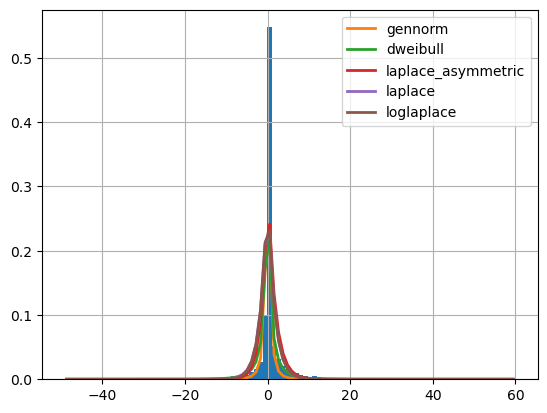

In [46]:
# but you call manually provide a smaller set of distributions
f1.summary()

Fitting 110 distributions:  11%|█▋             | 12/110 [00:43<06:13,  3.81s/it]SKIPPED bradford distribution (taking more than 30 seconds)
SKIPPED betaprime distribution (taking more than 30 seconds)
Fitting 110 distributions:  13%|█▉             | 14/110 [00:43<03:18,  2.06s/it]SKIPPED argus distribution (taking more than 30 seconds)
SKIPPED burr distribution (taking more than 30 seconds)
SKIPPED burr12 distribution (taking more than 30 seconds)
SKIPPED chi distribution (taking more than 30 seconds)
Fitting 110 distributions:  17%|██▌            | 19/110 [00:43<01:06,  1.36it/s]SKIPPED erlang distribution (taking more than 30 seconds)
SKIPPED exponpow distribution (taking more than 30 seconds)
Fitting 110 distributions:  39%|█████▊         | 43/110 [01:13<01:19,  1.18s/it]SKIPPED gengamma distribution (taking more than 30 seconds)
SKIPPED genhyperbolic distribution (taking more than 30 seconds)
SKIPPED geninvgauss distribution (taking more than 30 seconds)
Fitting 110 distributions: 

sumsquare_error          aic            bic  kl_div  ks_statistic  \
dgamma            0.006504  1406.724498 -106783.709328     inf      0.019231   
hypsecant         0.008732  1482.532744 -104541.277393     inf      0.016989   
dweibull          0.010497  1411.734615 -103125.574532     inf      0.016047   
gennorm           0.015212  1382.531087 -100290.170501     inf      0.017254   
laplace           0.019215  1344.607626  -98514.044802     inf      0.016995   

           ks_pvalue  
dgamma      0.006925  
hypsecant   0.024003  
dweibull    0.038635  
gennorm     0.020891  
laplace     0.023924

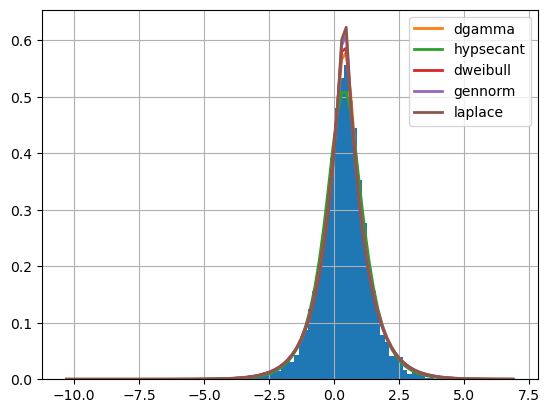

In [49]:
f2 = Fitter(error_tmax_dropna)
f2.fit()
f2.summary()

Fitting 110 distributions:   5%|▊               | 6/110 [00:25<08:24,  4.85s/it]SKIPPED alpha distribution (taking more than 30 seconds)
SKIPPED arcsine distribution (taking more than 30 seconds)
Fitting 110 distributions:   6%|█               | 7/110 [00:30<08:20,  4.86s/it]SKIPPED argus distribution (taking more than 30 seconds)
SKIPPED burr12 distribution (taking more than 30 seconds)
SKIPPED bradford distribution (taking more than 30 seconds)
Fitting 110 distributions:   9%|█▎             | 10/110 [00:30<03:26,  2.06s/it]SKIPPED betaprime distribution (taking more than 30 seconds)
SKIPPED burr distribution (taking more than 30 seconds)
Fitting 110 distributions:  11%|█▋             | 12/110 [00:30<02:14,  1.37s/it]SKIPPED beta distribution (taking more than 30 seconds)
SKIPPED chi distribution (taking more than 30 seconds)
SKIPPED chi2 distribution (taking more than 30 seconds)
SKIPPED crystalball distribution (taking more than 30 seconds)
Fitting 110 distributions:  12%|█▊        

sumsquare_error          aic            bic  kl_div  \
laplace_asymmetric         0.010860  1125.729148 -102879.935610     inf   
cauchy                     0.018177   893.189911  -98952.260080     inf   
gennorm                    0.020069  1028.482731  -98186.689620     inf   
laplace                    0.022105  1091.450983  -97457.033091     inf   
hypsecant                  0.053396  1171.078757  -90716.491429     inf   

                    ks_statistic     ks_pvalue  
laplace_asymmetric      0.019698  5.239311e-03  
cauchy                  0.044396  1.577795e-13  
gennorm                 0.041528  6.856296e-12  
laplace                 0.047666  1.573362e-15  
hypsecant               0.050440  2.439309e-17

/home/xinchenh/anaconda3/envs/winterdrawdown/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


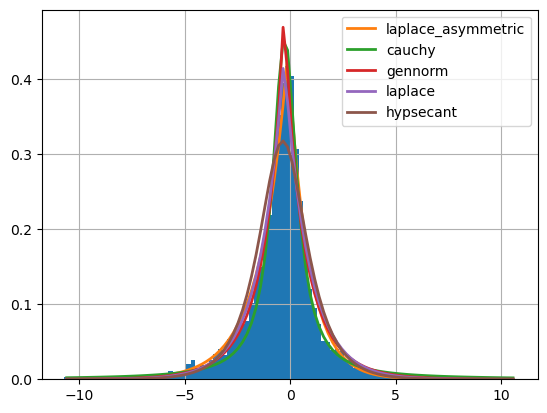

In [50]:
f3 = Fitter(error_tmin_dropna)
f3.fit()
f3.summary()

## Plot for each station

In [11]:
lake_mu_std = pd.read_csv('../data/Weather_Data/GHCN/lakes_mu_std.csv', index_col=0)

In [12]:
lake_mu_std

mu_tmax  std_tmax   mu_tmin  std_tmin  mu_prcp  std_prcp  \
Lake                                                                     
Ashmere      0.393889  0.724633 -0.293333  1.165095      0.0  1.633860   
Boon        -0.345556  3.288362  0.251667  1.058783      0.0  4.734056   
Brookhaven   0.116667  0.597701  0.443333  1.091853      0.0  1.161362   
Buel        -0.365000  2.365120  0.465556  1.448377      0.0  3.640844   
Garfield    -0.365000  2.365120  0.465556  1.448377      0.0  3.640844   
Goose       -0.365000  2.365120  0.465556  1.448377      0.0  3.640844   
Greenwater  -0.365000  2.365120  0.465556  1.448377      0.0  3.640844   
Hamilton     0.107778  3.096941  0.020000  1.092319      0.0  5.205527   
Onota        0.393889  0.724633 -0.293333  1.165095      0.0  1.633860   
Otis        -0.365000  2.365120  0.465556  1.448377      0.0  3.640844   
Richmond     0.393889  0.724633 -0.293333  1.165095      0.0  1.633860   
Stockbridge -0.365000  2.365120  0.465556  1.448377      0.0  3.640844   
Watatic      0.334444  2.607020  0.341111  1.066455      0.0  4.739876   
Wickaboag    0.116667  0.597701  0.443333  1.091853      0.0  1.161362   
Wyola        0.097222  2.995320  0.045556  0.858318      0.0  5.234281   

            GHCN station  
Lake                      
Ashmere      USW00014763  
Boon         USC00194580  
Brookhaven   USW00014702  
Buel         USC00194131  
Garfield     USC00194131  
Goose        USC00194131  
Greenwater   USC00194131  
Hamilton     USC00192107  
Onota        USW00014763  
Otis         USC00194131  
Richmond     USW00014763  
Stockbridge  USC00194131  
Watatic      USC00190192  
Wickaboag    USW00014702  
Wyola        USC00194154

In [15]:
def plot_hist(station, item, mu, std, ax):
    # plot histogram of the error
    # and a empirical distribution
    
    # Load lat and lon for aquire daymet data
    lat = station_coords.loc[station, 'LATITUDE']
    lon = station_coords.loc[station, 'LONGITUDE']
    data_daymet = daymetpy.daymet_timeseries(lon=lon, lat = lat, start_year=2000, end_year=2022).loc[:, ["tmax", "tmin", "prcp"]]
    
    # calculate error for each object
    # tmax
    error = data_daymet[item] - data_obs.loc[data_obs['STATION'] == station,item]
    error_dropna = error.dropna()
    ax.hist(error_dropna, bins=25, density=True, alpha=0.6, color='g', label = "Errors")
    
    # empirical distribution
    # Plot the PDF.
    x = np.linspace(error.min(), error.max(), 100)
    p = laplace.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2, label = "Fitted Normal Distribution")
    
    # title
    title = station + ' ' + item + " error distribution ~ $Laplace(%.2f, %.2f)$" % (mu, std)
    ax.set_title(title)
    ax.set_xlabel("$\epsilon({ite})$".format(ite = item))
    ax.set_ylabel("Probability Density")

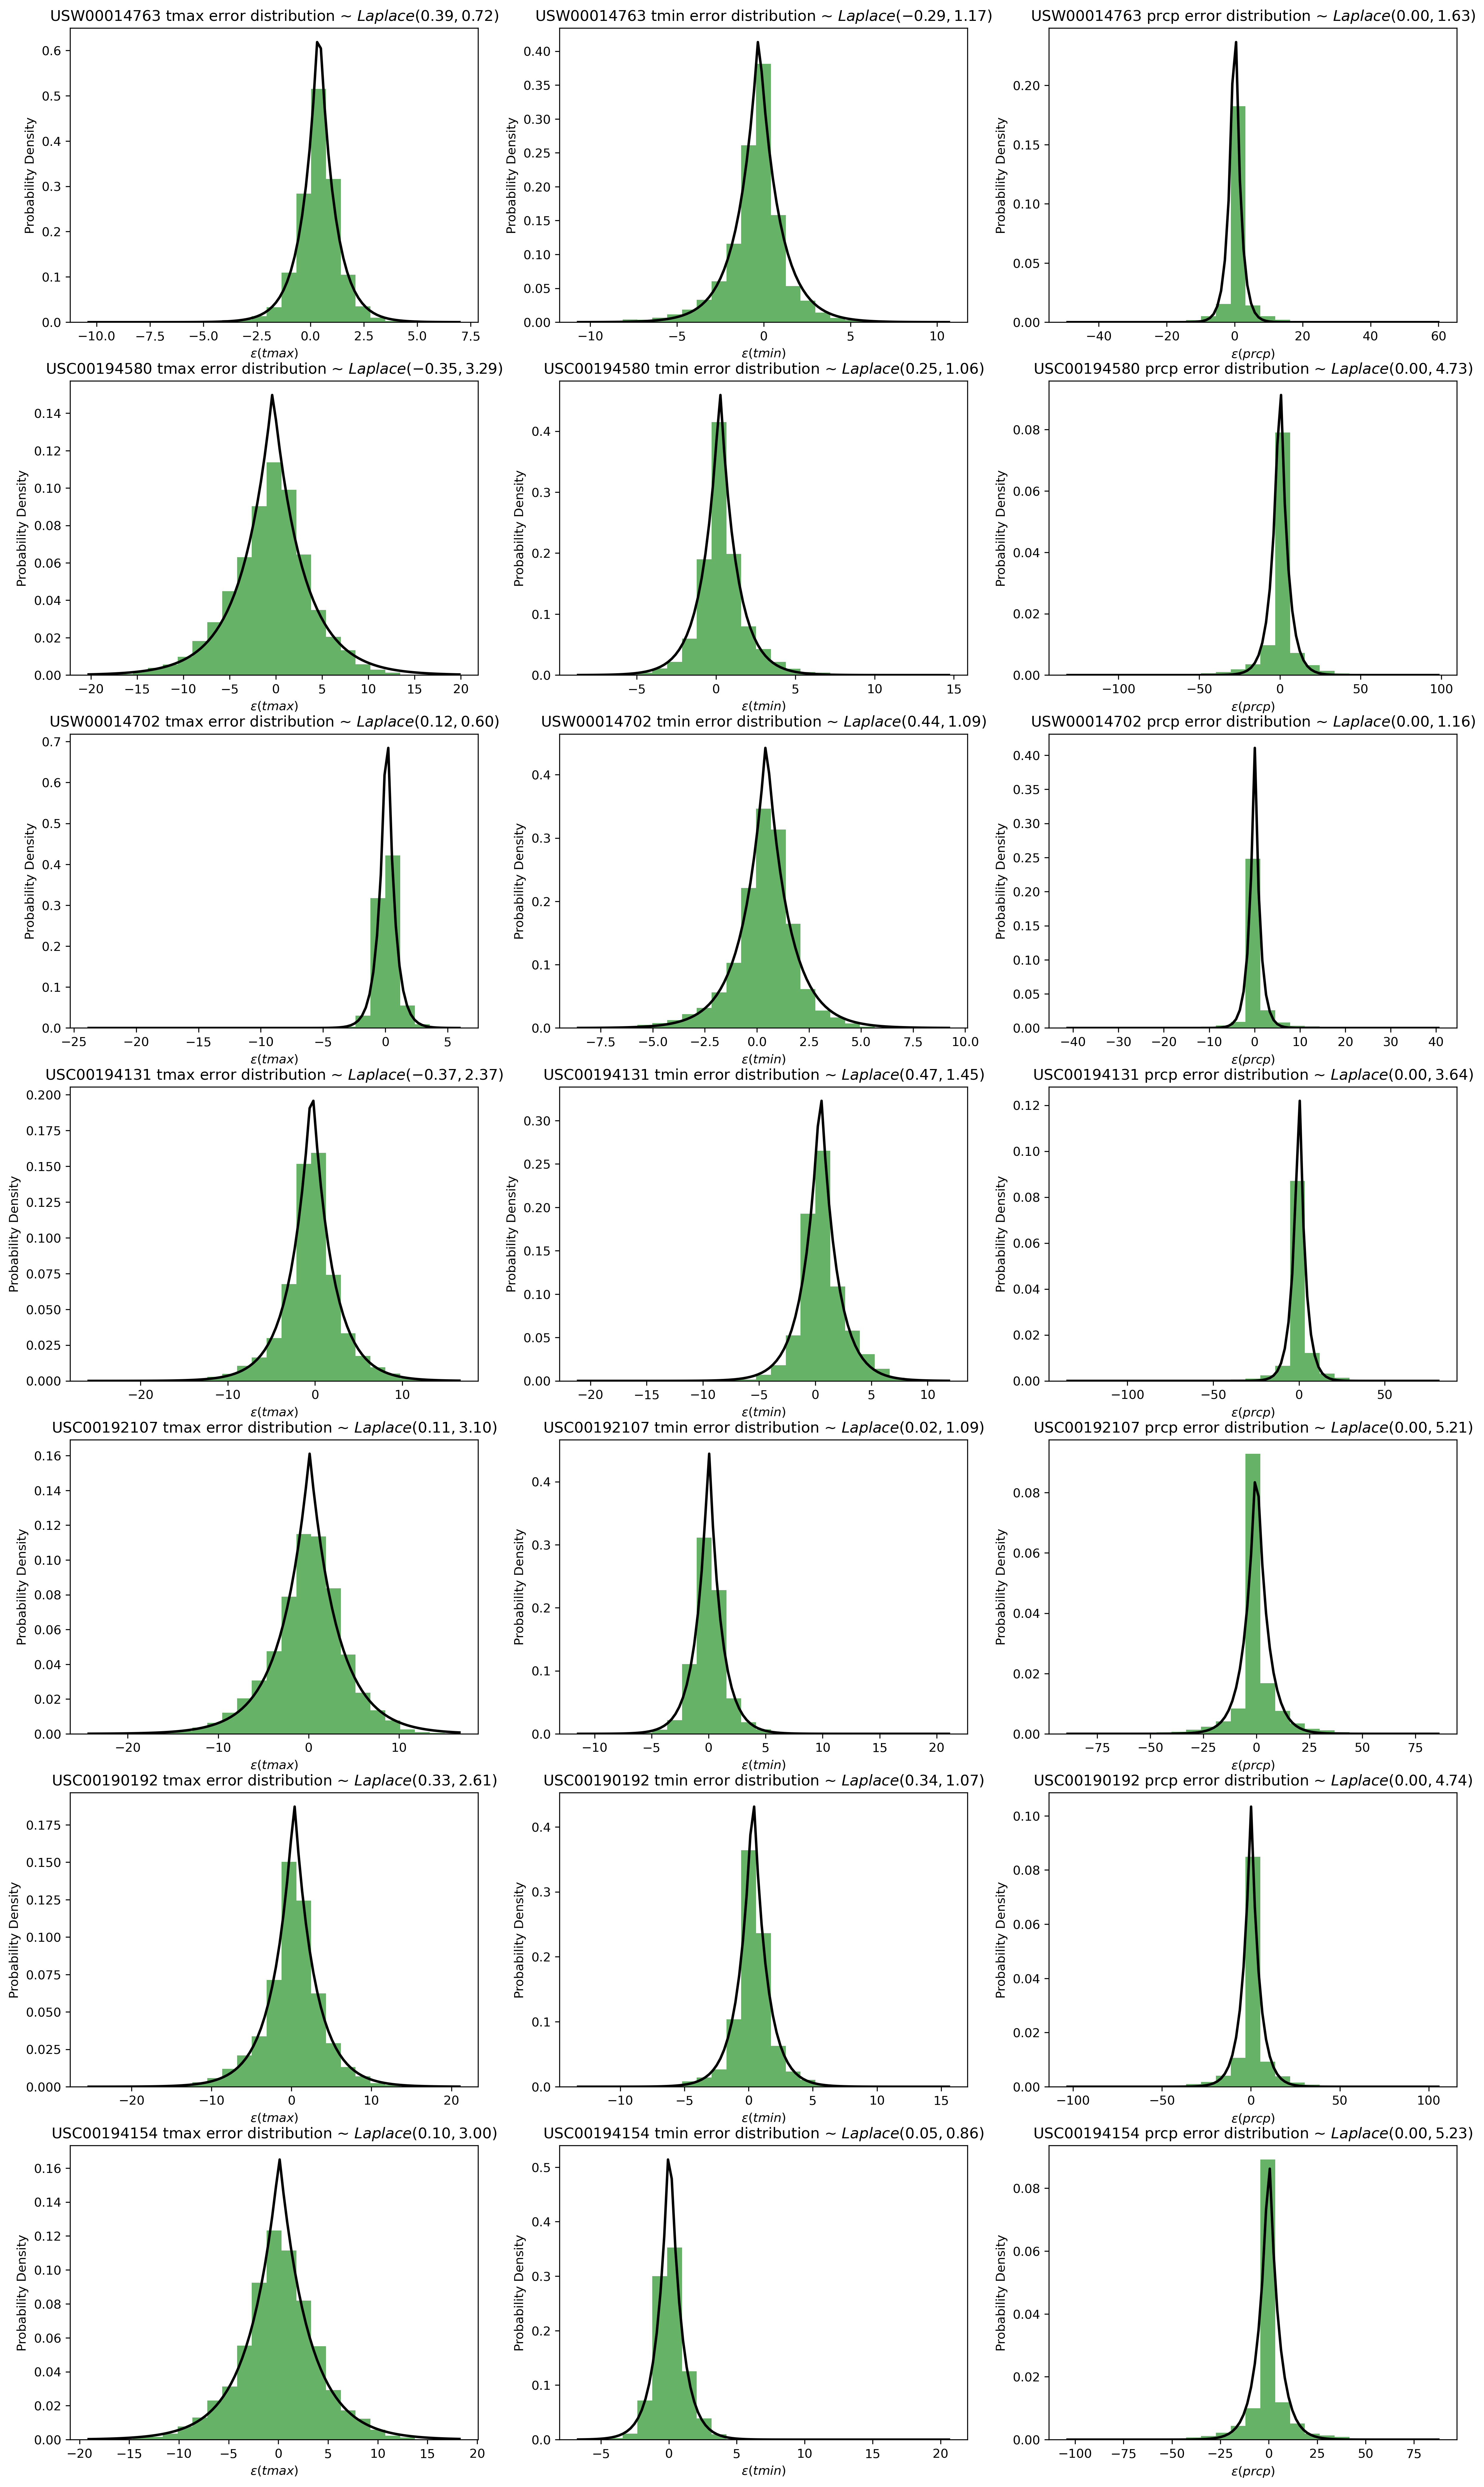

In [37]:
# plot histogram for each station

fig_tmax, axes = plt.subplots(7,3, figsize=(20, 35), dpi = 300)

for i, station in enumerate(lake_mu_std['GHCN station'].unique()):
    
    # print(station)
    
    lnames = lake_mu_std['GHCN station'] == station
    
    plot_hist(station,
              'tmax', 
              lake_mu_std.loc[lnames, 'mu_tmax'][0], 
              lake_mu_std.loc[lnames, 'std_tmax'][0],
              axes[i,0])
    
    plot_hist(station,
              'tmin', 
              lake_mu_std.loc[lnames, 'mu_tmin'][0], 
              lake_mu_std.loc[lnames, 'std_tmin'][0],
              axes[i,1])
    
    plot_hist(station,
              'prcp', 
              lake_mu_std.loc[lnames, 'mu_prcp'][0], 
              lake_mu_std.loc[lnames, 'std_prcp'][0],
              axes[i,2])

In [39]:
# fig_tmax.savefig('../docs/paper_1/daymet_errors/seven_stations.pdf', bbox_inches='tight')